# TDA & Deep Learning Project Report

Floran DEFOSSEZ
Gatien Chopard
Sebastien ROIG

Ce notebook a pour objectif de synthétiser et illustrer les concepts et résultats de l'article de Bertand Michel and Frédéric Chazal "An Introduction to Topological Data Analysis: Fundamental and Practical Aspects for Data Scientists". Nous allons uliliser pour cela la librairie GUDHI.

# Simplicial Complexes

Un complexe simplicial est un objet géométrique permettant de décrire certains espaces topologiques en généralisant la notion de triangulation d'une surface. Il se présente comme un graphe avec des sommets reliés par des arêtes, sur lesquelles peuvent se rattacher des faces triangulaires, elles-mêmes bordant éventuellement des faces de dimension supérieure. On peut se représenter un complexe comme un ensemble de sommets munis d'hyper-arêtes (simplexes) : les arêtes de dimention deux relient 2 points c'est une ligne, les arêtes de dimension trois relient 3 points c'est une surface etc.

Afin de d'analyser le structure topologique d'un nuage de point, il est possible de se servir d'un complexe simplicial construit à partir de ces données. Il existe de nombreuses méthodes de construction, nous allons vous présenter le compexe de Vietoris–Rips et le compexe de Alpha.

#### The Vietoris-Rips

Le complexe de Vietoris-Rips consiste à considérer toutes les simplexes $[x_1 ... x_n]$ tel que pour toute paire d'indice $(i,j)$, la distance $d(x_i,x_j) < \alpha$ .

Ci-dessous sont représenté les complexes de Rips à partir d'un ensemble de 100 points échantillonées sur une couronne du plan euclidien pour 2 valeurs de alpha.

In [1]:
import numpy as np
import gudhi as gd
import kmapper as km
import matplotlib.pyplot as plt
import utils
%matplotlib inline


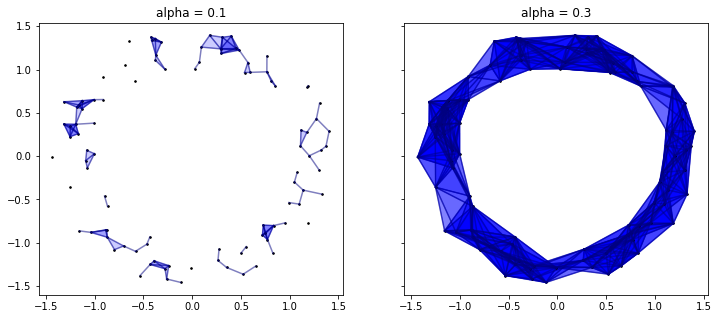

In [5]:

points = utils.anulus(100)

alpha = [0.1,0.3]
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))

for i in range(2):
    rips_complex = gd.RipsComplex(points=points)
    simplex_tree = rips_complex.create_simplex_tree(2)
    triangles = np.array([x[0] for x in simplex_tree.get_skeleton(2) if len(x[0]) == 3 and x[1] <= 2*alpha[i]])
    lines = np.array([x[0] for x in simplex_tree.get_skeleton(2) if len(x[0]) == 2 and x[1] <= 2*alpha[i]])

    ax[i].set_title(f"alpha = {alpha[i]}")
    for triangle in triangles:
        ax[i].fill(points[triangle][:,0], points[triangle][:,1], color='b', alpha=0.2)
    for line in lines:
        ax[i].plot(points[line][:,0], points[line][:,1], c='navy', alpha=0.5)
    ax[i].scatter(points[:,0],points[:,1],s=2.5,c='black')
plt.show()



On remarque que pour une valeur d'alpha trop faible, la filtration est trop restrictive et les simplexes ne parviennent pas à se rejoindre pour reformer un anneau. Par ailleurs, si on avait choisi une valeur alpha très grande, toutes les simplexes constructibles aurait été accepté et on aurait obtenu un disque.

Choisir la bonne valeur de filtration aplha est donc primordiale pour construire un complexes dont les propriétés topologiques ressemble à l'object échantillonné.

#### Complexe Alpha

Le complexe Alpha consiste à considérer tous les simplexes $[x_1...x_n]$ tel que le cercle de dimension n circonscrit passant par l'ensembles des points $x_1,...x_n$ à un rayon dont le carré est inférieur à $\alpha$ et ne contient aucun autre point. Ces conditions permettent de constituer des simplexes qui ne se chevauchent pas.

Représentons de la même manière les complexes Alpha issue du même nuage de point.

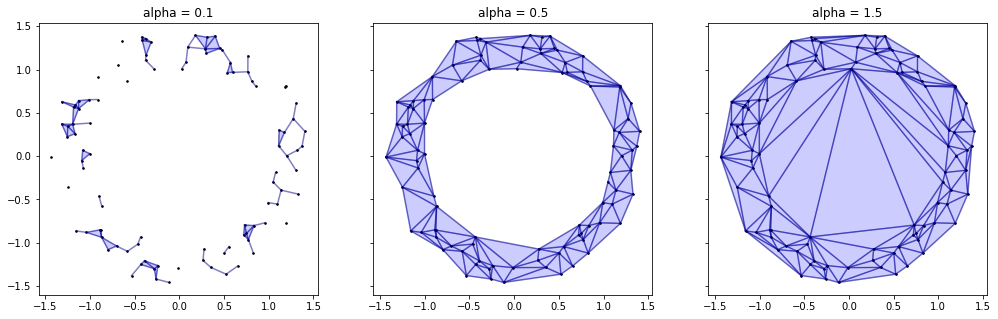

In [11]:
alpha = [0.1,0.5,1.5]

cech_complexe = gd.AlphaComplex(points=points)
simplex_tree = cech_complexe.create_simplex_tree()

fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(17, 5))
for i in range(3):
    triangles = np.array([s[0] for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3 and s[1] <= alpha[i]**2])
    lines = np.array([x[0] for x in simplex_tree.get_skeleton(2) if len(x[0]) == 2 and x[1] <= alpha[i]**2])
    ax[i].set_title(f"alpha = {alpha[i]}")
    for triangle in triangles:
        ax[i].fill(points[triangle][:,0], points[triangle][:,1], color='b', alpha=0.2, )
    for line in lines:
        ax[i].plot(points[line][:,0], points[line][:,1], c='navy', alpha=0.5)
    ax[i].scatter(points[:,0],points[:,1],s=2.5,c='black')
plt.show()

Globalement, nous obtenons effectivement le même comportement qu'avec la méthode de Rips. Cependant, nous constatons qu'elle est bien plus rapide à être calculé, nous proposons donc la construction d'un complexe sur un nuage de point en 3 dimensions échantillonées sur la surface d'un tore.

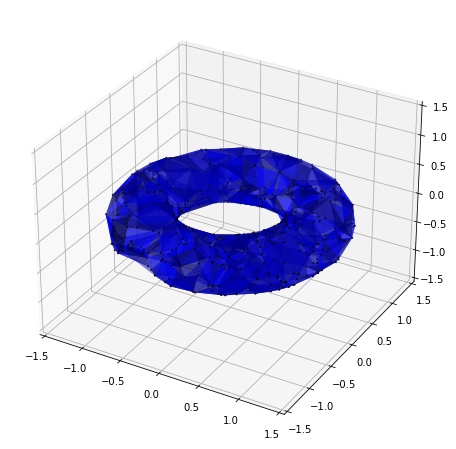

In [12]:
points = utils.torus(400,1,0.4)

cech_complexe = gd.AlphaComplex(points=points)
simplex_tree = cech_complexe.create_simplex_tree()
triangles = np.array([s[0] for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3 and s[1] <= 0.1])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(points[:, 0], points[:, 1], points[:, 2], triangles = triangles, alpha=0.5, color='b')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, c='black')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)
plt.show()

On voit que le complexe semble bien récupérer la structure de tore

# The Mapper Algorithm

L'algorithme mapper consiste à exploiter le théorème du nerf pour construire des complexes simpliciaux homotope équivalent à un ensemble $\mathbb{X}$

Soit $\mathcal{U}=(U_i)_{i\in I}$ un recouvrement de $\mathbb{X}$,
$$\mathbb{X} = \bigcup_{i \in I}U_i$$
Le nerf de $\mathcal{U}$ est le complexe simplicial $\mathcal{C}(\mathcal{U})$ tel que
$$\sigma = [x_{i_0}, ..., x_{i_n}] \in \mathcal{C}(\mathcal{U}) \Leftrightarrow \bigcap_{j=0}^{n}U_{i_j} \ne \emptyset $$


Le théorème nerf affirme que si $ \forall J \subset I, \bigcap_{j \in J}U_j$ est vide ou contractible alors $\mathbb{X}$ et $\mathcal{C}(\mathcal{U})$ sont homotope équivalent

L'aglorithme mapper consiste construire un recouvrement du nuage de point, il s'agit souvent de prendre l'image réciproque par une fonction de plongment simple par des intervalles réguliers qui se chevauchent. On réalise des opération de clusterisation sur ces préimage pour séparer les composantes connexes. Enfin, on construit le nerf de ce recouvrement.

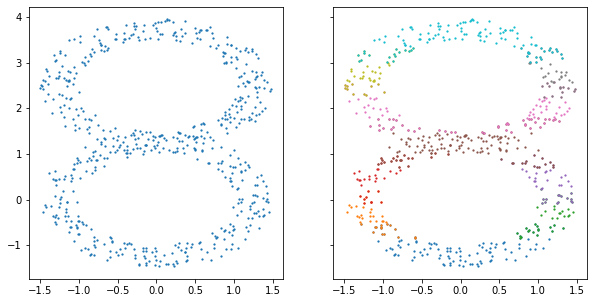

In [2]:
points = utils.anulus(300)
points[:,1] += 2.5
points = np.concatenate((points, utils.anulus(300)))


mapper = km.KeplerMapper()
projected_data = mapper.fit_transform(points, projection=[1])
cover = km.Cover(n_cubes=7, perc_overlap=0.3)
graph = mapper.map(projected_data, points, cover=cover)

# mapper.visualize(graph, path_html="output/two_cirles_keplermapper.html");

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
ax[0].scatter(points[:,0], points[:,1], s=1.5)
for k,e in graph['nodes'].items():
    ax[1].scatter(points[:,0][e], points[:,1][e], s=1.5)
plt.show()


Sur le premier plot est affiché le nuage de point qui forme 2 anneaux qui se touchent. On recouvre ce nuage de points en prenant les images inverses de la projection sur la deuxième coordonnée par 7 intervalles réguliers qui se chevauchent de 30%. Ces parties sont ensuites scindé en clusters qui sont représenté sur la figure de droite. Enfin, on obtient le complexe nerf associé si dessous.

<img src="images/complexe_1.png"  style="width: 600px;"/>

Il est possible de visualiser ce complexe dans un navigateur avec le fichier output/two_cirles_keplermapper.html

# Geometric Reconstruction and Homology Inference

Savoir construire un complexe simplicale à partir d'un nuage de point est interessant. Mais être capable de dire que le complexe obtenu possèdes les même propriétés topologiques que l'object sur lequel les points ont été échantillonées l'est d'avantage. Faire cet inférence statistique impose des hypothèses de régularité que nous ne détaillerons pas ici.

En pratique lorque que l'on a le nuage de points de $\mathbb{R}^d$ : $\mathbb{X} = \{x_1,...x_n\}$ échantillonée sur un ensemble $\mathcal{M}$, on construit une famille d'ensembles indéxés par $r\in\mathbb{R}_+$ constitués par l'union des boules centrés en $x_i$ et de rayon $r$, on appel cet ensemble le r-offset de $\mathbb{X}$.

Pour certaines valeurs de $r$ bien choisis, on peut relier la topologie de cette union de boules à celle de $\mathcal{M}$. On peut ensuite récupérer ces données topologiques à partir du théorème nerf en anaysant les complexes.

#### r-offset

On peut facilement se convaincre que sous les bonnes conditions, le r-offset d'un nuage de point est similaire à l'objet échantilloné :

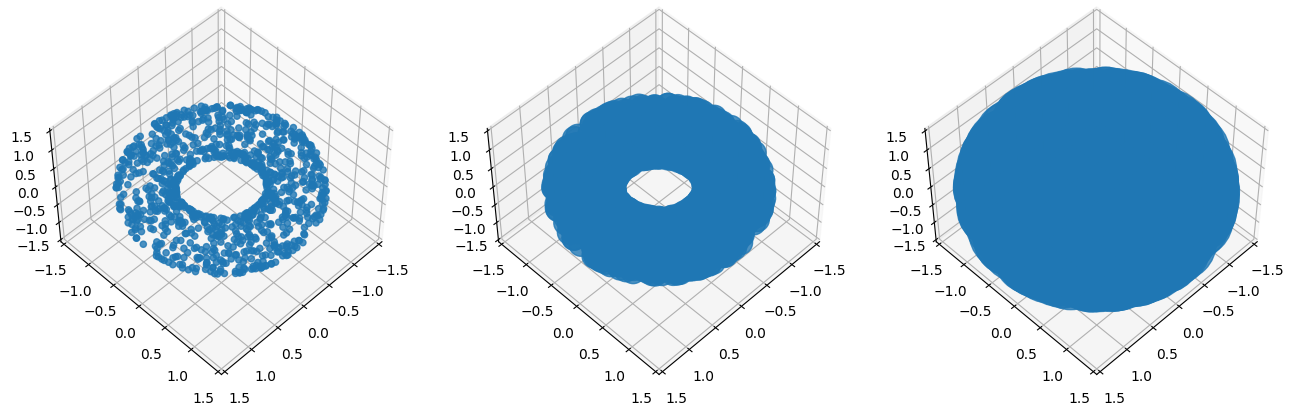

In [51]:
points = utils.torus(1000,1,0.4)

fig = plt.figure(figsize=plt.figaspect(0.3))
r = [20,300,3000]
for i in range(1,4):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    ax.scatter3D(points[:,0], points[:,1], points[:,2],alpha=0.8,s=r[i-1])
    ax.view_init(elev=50, azim=45)
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_zlim(-1.5, 1.5)

plt.show()

Voici trois repésentation du r-offset d'un nuage de points échantillonés sur la surface d'un tore. On voit que le r-offset centrale sur la figure ci-dessus forme un ensemble topologiquement équivalent au tore.

#### Betti numbers

Une propriété importante que l'on souhaite inférer sont les nombres de Betti. Il s'agit d'une suite d'entier naturel qui représente les nombres "trous" en chaque dimentions.
- $\beta_0$ est le nombre de composantes connexes
- $\beta_1$ est le nombre de courbes fermées indépendantes contenues dans l'ensemble
- $\beta_2$ est le nombre de cavité (bulles) contenues dans l'ensemble

Lorsque deux ensembles sont homotopes équivalent, ils partages les mêmes nombres de betti. Ainsi, nous souhaitons calculer les nombres de Betti d'un complexe simplical, il faut pour cela faire un peu d'homologie simpliciale

Soit $K$ un complexe simplicale, on défini l'éspace des k-chaines $C_k(K)$ comme étant l'ensemble des sommes des k-simplexes de $K$. Si $\{\sigma_1,...\sigma_p\}$ est l'ensemble des k-simplexes de $K$ alors

$$ C_k(K) = \left\{ \sum_{i=1}^p\epsilon_i\sigma_i : \epsilon_i \in \mathbb{Z}_2 \right\}$$

On défini l'opérateur frontière $\partial_k$ pour les k-simplexes : Si $\sigma = [v_0,...v_k]$ est un k-simplexe alors sa frontière est la (k-1)-chaine

$$ \partial_k(\sigma) = \sum_{i=0}^k (-1)^i[v_0,...\hat v_i,...v_k] $$

Puisque l'ensemble de k-simplexes forment une base pour $C_k(K)$ alors on peu étendre la définion de l'opérateur frontière comme étant une application linéaire de $C_k(K)$ dans $C_{k-1}(K)$


Le noyau de l'opérateur frontière forme l'ensemble des k-cycles de K
$$Z_k(K) = \left\{ c\in C_k(K) : \partial_k(c) = 0 \right\}$$

Et son image forme l'ensemble des des k-frontières de K
$$ B_k(K) = \left\{ c\in C_k(K) : \exists c' \in C_{k+1}(K), \partial_{k+1}(c') = c \right\} $$

On définit le groupe d'homologie simplicale :
$$ H_k(K) = Z_k(K)/B_k(K) $$

Il s'agit donc de l'ensembles de k-chaines qui sont des cycles mais qui ne sont pas l'image d'un (k+1)-simplexe. Ces k-chaines entourent les cavités de dimention k du complexe K. Ainsi on a le nombre de Betti $\beta_k=\#H_k(K)$

On pourrai penser qu'avec ce cadre mathématique, nous pouvons calculer les nombre de Betti de $\mathcal{M}$ à partir du r-offset de $\mathbb{X}$ mais d'un point de vue pratique, cette théorie soulève plusieurs difficultés : Premièrement, il faut respecter des hypothèses de régularité sur $\mathcal{M}$ qui peuvent être trop restrictive ; deuxièmement, le calcul du nerf d'une union de boules (le r-offset) nécessite l'utilisation d'outils très sophostiqués ; troisièmement, l'estimation des nombres de Betti repose sur le paramètre d'échelle r, dont le choix peut poser problème. Pour répondre à ces problème nous utiliserons l'homologie persistante.

# Persistent Homology

#### Filtration



La filtration d'un complexe simplicial $K$ est une famille de sous-complexes $(K_r)_{r \in T}$ ($T \subset \mathbb{R}$) emboités les uns dans les autres.
Cette famille doit être telle que pour tout $r, r' \in T$, si $r \le r'$, alors $K_r \subseteq K_r'$ et de plus $K = \cup _{r \in T} K_r$. Le paramètre r est appelé paramètre d'échelle.

En pratique des exemples de filtrations peuvent être des filtrations construites sur les données comme le complexe de Vietoris-Rips $(Rips_r(\mathbb{X}))_{r \in \mathbb{R}}$ où le paramètre r sera le paramètre d'échelle, ou alors des filtrations construites à partir de l'image réciproque des sous-niveaux d'une fonction $f$.

Si on reprend l'exemple des r-offsets, on peut construire en construire une filtration, c'est la filtration correspondant à $(F_r = d_k^{-1}([0, r]))_{r \in [0, +\infty[}$. Avec $d_k(x) = inf_{y \in K} \|x - y\|$. C'est donc une filtration par sous niveaux de la fonction $d_k$.

#### Homologie persistante

Lorsque l'on se restreint aux cas simples comme ceux que nous allons étudier, c'est à dire des complexes simpliciaux finis, le principe est de regarder l'évolution des groupes d'homologies $H_k(K_r)$ en fonction du paramètre d'échelle r. En dimension 0, cela revient à regarder les composantes connexes de notre sous-complexe, en dimension 1, les cycles, etc... On encode souvent cette évolution dans des codes barres de persistance qui indique lorsqu'il y a naissance et mort d'une cavité de dimension k.

Pour mieux illustrer cela nous allons d'abord nous intéresser à des exemples :

<img src="images/persistence.png"  style="width: 600px;"/>

On peut voir sur cet exemple différentes phases se dégager :

- a) $r = 0$ Il y a autant de composantes connexes que de points dans l'ensemble de données. Les codes barres rouges corresondent ici aux "trous" de dimension 0 et ils continueront jusqu'à ce qu'il y ait intersection des zones oranges (Complexes de Čech).

- b) Les zones oranges ont commencées à se recouvrir et par conséquent les codes barres s'arrêtent d'évoluer, cela correspond à la "mort" d'une composante connexe car elle fusionne avec une autre. 

- c) On voit l'apparition des 2 cycles c'est à dire de "trous" de dimensions 1, les codes barres bleus apparaissent. etc...

Finalement, on peut représenter ces codes barres d'une manière différente à l'aide des diagrammes de persistances. Chaque code barre à son point correspondant dans le diagramme de persistance avec en abscisse, sa date de naissance et en ordonnée sa date de mort. On trace une ligne diagonale qui correspondrait aux points morts aux mêmes instants que leurs naissances, et ainsi chaque point proche de cette diagonale est peu significatif.

Passons à l'exemple très simple du 8 déjà utilisé précédemment.

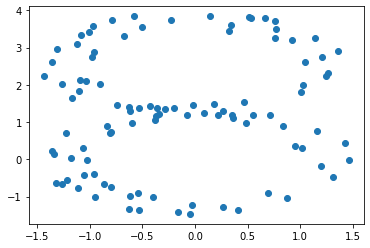

In [12]:
points = utils.anulus(50)
points[:,1] += 2.5
points = np.concatenate((points, utils.anulus(50)))

plt.scatter(points[:,0], points[:,1])
plt.show()

Pour cet ensemble de données, on observe 2 caractéristiques topologiques flagrantes qui sont les 2 "trous" de dimension 1. On s'attend donc à un diagramme de persistance qui laisse apparaitre ces caractéristiques.

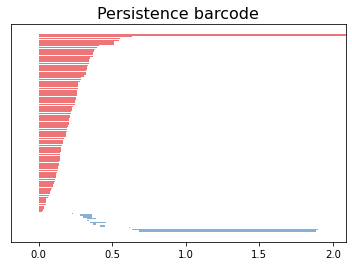

In [55]:
rips_complex = gd.RipsComplex(points=points)
simplex_tree = rips_complex.create_simplex_tree(max_dimension = 2)
BarCodes_Rips0 = simplex_tree.persistence()
gd.plot_persistence_barcode(BarCodes_Rips0);

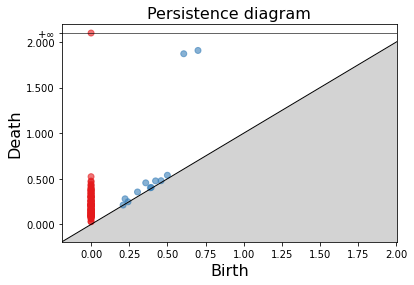

In [18]:
gd.plot_persistence_diagram(BarCodes_Rips0);

En effet, on observe bien que ces 2 caractéristiques apparaissent bien à la fois sur les codes barres et sur le diagramme de persistance. On observe aussi un point rouge à l'infini qui correspond à la composante connexe qui survit jusqu'à la fin.

#### Distance Bottleneck

La distance Bottleneck permet d'avoir une mesure sur cette espace des diagramme de persistance et ainsi d'avoir un moyen de les comparer. Elle s'exprime sous la forme suivante :
$$
d_b(dgm1,dgm2) = \underset{matching \ m}{inf} \ \underset{(p,q) \in m}{max} \|p - q\|_\infty
$$
Où le matching entre les deux diagrammes est un sous-ensemble $m \subseteq dgm1 \times dgm2$ tel que tous les points de dgm1 \ $\Delta$ et dgm2 \ $\Delta$ apparaissent une seule fois dans m.

Illustration :

<img src="images/MatchingDiag.png"  style="width: 400px;"/>

Essayons donc de voir sur des exemples très simples si la distance Bottleneck montre bien la différence entre des données.

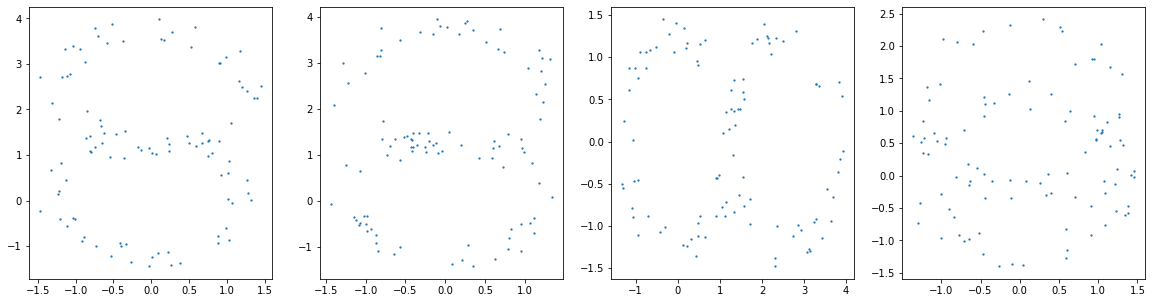

In [48]:
sample1 = utils.anulus(50)
sample1[:,1] += 2.5
sample1 = np.concatenate((sample1, utils.anulus(50)))
rips_complex = gd.RipsComplex(points=sample1)
simplex_tree1 = rips_complex.create_simplex_tree(max_dimension = 2)

sample2 = utils.anulus(50)
sample2[:,1] += 2.5
sample2 = np.concatenate((sample2, utils.anulus(50)))
rips_complex = gd.RipsComplex(points=sample2)
simplex_tree2 = rips_complex.create_simplex_tree(max_dimension = 2)

sample3 = utils.anulus(50)
sample3[:,0] += 2.5
sample3 = np.concatenate((sample3, utils.anulus(50)))
rips_complex = gd.RipsComplex(points=sample3)
simplex_tree3 = rips_complex.create_simplex_tree(max_dimension = 2)

sample4 = utils.anulus(50)
sample4[:,1] += 1
sample4 = np.concatenate((sample4, utils.anulus(50)))
rips_complex = gd.RipsComplex(points=sample4)
simplex_tree4 = rips_complex.create_simplex_tree(max_dimension = 2)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].scatter(sample1[:,0], sample1[:,1], s=1.5)
ax[1].scatter(sample2[:,0], sample2[:,1], s=1.5)
ax[2].scatter(sample3[:,0], sample3[:,1], s=1.5)
ax[3].scatter(sample4[:,0], sample4[:,1], s=1.5)

plt.show()


Sur cette exemple, nous nous attendons à ce que la figure 1, 2 et 3 aient des diagrammes de persistances très similaires, et donc une distance Bottleneck plutôt faible entre les 3 diagrammes. Au contraire avec l'ensemble de données 4, le diagramme de persistance devrait être assez différent.

distance entre le diagramme 1 et 2 : 0.13769513661890387
distance entre le diagramme 1 et 3 : 0.15945473303307744
distance entre le diagramme 1 et 4 : 0.6589171345467313


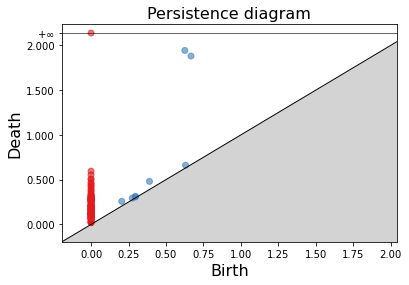

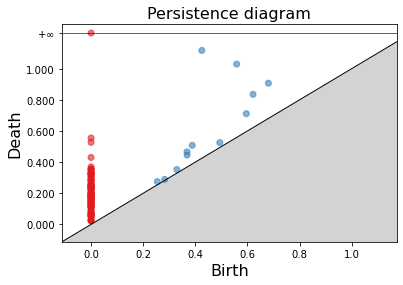

In [56]:
BarCodes_Rips1 = simplex_tree1.persistence()
BarCodes_Rips2 = simplex_tree2.persistence()
BarCodes_Rips3 = simplex_tree3.persistence()
BarCodes_Rips4 = simplex_tree4.persistence()

I1 = simplex_tree1.persistence_intervals_in_dimension(1)
I2 = simplex_tree2.persistence_intervals_in_dimension(1)
I3 = simplex_tree3.persistence_intervals_in_dimension(1)
I4 = simplex_tree4.persistence_intervals_in_dimension(1)



gd.plot_persistence_diagram(BarCodes_Rips1);
gd.plot_persistence_diagram(BarCodes_Rips4);



print('distance entre le diagramme 1 et 2 :', gd.bottleneck_distance(I1, I2))
print('distance entre le diagramme 1 et 3 :', gd.bottleneck_distance(I1, I3))
print('distance entre le diagramme 1 et 4 :',gd.bottleneck_distance(I1, I4))



Ce résultat confirme bien nos attentes et montre bien la dissimilarité entre des diagrammes qui correpondent à peu près aux mêmes objets topologiques et un diagramme très différents.

#### Vectorisation

Afin d'utiliser ces caractéristiques topologiques extraites, il serait souhaitable de trouver un moyen de retranscrire ces informations de manières vectorielles, c'est à dire utilisable par des algorithmes de Machine Learning par exemple. En effet, on a pu définir précédemment une mesure parmis plusieurs existantes sur cette espace des diagrammes. Cependant, cela ne constitue pas un espace Hilbertien utilisable par nos algorithmes usuels. De ce fait, dans ce paragraphe nous allons voir des représentations plus confortables pour les diagrammes de persistance.

#### Persistance landscape

# Statistical Aspects of Persistent Homology